# Generative Adversarial Networks (GANs): A Simple Example with MNIST

This notebook introduces **Generative Adversarial Networks (GANs)** using the MNIST handwritten digits dataset.

We will:
- Explain the basic idea of GANs in simple terms.
- Load the MNIST dataset of handwritten digits (0–9).
- Build a very small **Generator** and **Discriminator** using PyTorch.
- Train the GAN to create fake digit images.
- Visualize the generated digits as training progresses.

This notebook is meant for undergraduate students who have some basic experience with Python and Jupyter, but no prior experience with GANs.


In [4]:
# If running on a fresh environment, you may need to install PyTorch and torchvision.
# You can uncomment and run the line below if PyTorch is not installed.
!pip3 install torch torchvision

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np


  Obtaining dependency information for torch from https://files.pythonhosted.org/packages/1e/ce/7d251155a783fb2c1bb6837b2b7023c622a2070a0a72726ca1df47e7ea34/torch-2.9.1-cp311-none-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for torchvision from https://files.pythonhosted.org/packages/e7/69/30f5f03752aa1a7c23931d2519b31e557f3f10af5089d787cddf3b903ecf/torchvision-0.24.1-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for filelock from https://files.pythonhosted.org/packages/76/91/7216b27286936c16f5b4d0c530087e4a54eead683e6b0b73dd0c64844af6/filelock-3.20.0-py3-none-any.whl.metadata
  Obtaining dependency information for sympy>=1.13.3 from https://files.pythonhosted.org/packages/a2/09/77d55d46fd61b4a135c444fc97158ef34a095e5681d0a6c10b75bf356191/sympy-1.14.0-py3-none-any.whl.metadata
  Obtaining dependency information for networkx>=2.5.1 from https://files.pythonhosted.org/packages/07/c7/d64168da60332c17d24c0d2f08bdf3987e8d1ae9d84b5bbd0eec

In [5]:
# Use GPU if available, otherwise CPU.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

## What is a GAN?

A **Generative Adversarial Network (GAN)** is made of two neural networks that *compete* with each other:

- **Generator (G)**: takes random noise as input and tries to create **fake images** that look real.
- **Discriminator (D)**: takes an image as input and tries to decide whether it is **real (from the dataset)** or **fake (from the generator)**.

You can think of it like:

- The **Generator** is a *forger* trying to create fake art.
- The **Discriminator** is a *detective* trying to spot fake art.
- Over time, both get better: the generator makes more realistic images, and the discriminator becomes a better critic.

In this notebook, we train a simple GAN to generate **28×28 pixel images of digits** using the MNIST dataset.


In [6]:
# Transform: convert image to tensor and scale to [-1, 1] (helpful for Tanh output later)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # from [0,1] to [-1,1]
])

# Download and load training data
mnist_dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)

batch_size = 64
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

len(mnist_dataset), batch_size


100%|██████████████████████████████████████| 9.91M/9.91M [00:00<00:00, 12.5MB/s]
100%|███████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 353kB/s]
100%|██████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 3.21MB/s]
100%|██████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 1.07MB/s]


(60000, 64)

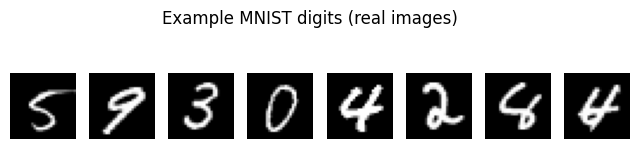

In [7]:
# Get one batch of images
real_batch = next(iter(dataloader))
images, labels = real_batch

# Plot first 8 images in the batch
plt.figure(figsize=(8, 2))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    img = images[i].squeeze().numpy()  # remove channels dimension
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.suptitle("Example MNIST digits (real images)")
plt.show()


In [8]:
# Size of the noise vector (input to the generator)
z_dim = 64

# Size of flattened image (28 x 28)
img_size = 28 * 28

# Training settings
num_epochs = 5          # increase later if you want better images
lr = 2e-4               # learning rate
print_every = 200       # how often to print training progress

z_dim, img_size


(64, 784)

In [9]:
class Generator(nn.Module):
    """
    The Generator takes random noise (z) as input and outputs a fake image.
    We use a small fully connected network (MLP).
    """
    def __init__(self, z_dim, img_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, img_size),
            nn.Tanh()  # output values in [-1, 1]
        )
        
    def forward(self, z):
        x = self.model(z)
        # reshape to (batch_size, 1, 28, 28)
        return x.view(-1, 1, 28, 28)

generator = Generator(z_dim, img_size).to(device)
generator


Generator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [10]:
class Discriminator(nn.Module):
    """
    The Discriminator takes an image and outputs a single number between 0 and 1:
    - 1 means 'real'
    - 0 means 'fake'
    """
    def __init__(self, img_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(img_size, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 1),
            nn.Sigmoid()  # output probability
        )
        
    def forward(self, x):
        # flatten image to vector
        x = x.view(x.size(0), -1)
        return self.model(x)

discriminator = Discriminator(img_size).to(device)
discriminator


Discriminator(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=128, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [11]:
# Binary Cross Entropy loss: good for classifying real vs fake
criterion = nn.BCELoss()

# Adam optimizers for both networks
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)


## How Training Works (High-Level)

We train the GAN in two steps for each batch:

1. **Train the Discriminator (D)**
   - Give D some real images with label = 1.
   - Give D some fake images from G with label = 0.
   - Update D so it gets better at telling real from fake.

2. **Train the Generator (G)**
   - Generate fake images from random noise.
   - Let D try to classify them.
   - This time, we **pretend the fake images are real** (label = 1).
   - Update G so it gets better at fooling D.

We repeat this many times. Over time:
- The generator produces more realistic images.
- The discriminator becomes a sharper critic.

We will print the losses during training to see how they change over epochs.


In [12]:
# For saving generated samples to visualize progress
fixed_noise = torch.randn(32, z_dim).to(device)

G_losses = []
D_losses = []

step = 0

for epoch in range(num_epochs):
    for batch_idx, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        batch_size_curr = real_imgs.size(0)
        
        # ============================
        # 1. Train Discriminator
        # ============================
        discriminator.zero_grad()
        
        # Real images: label = 1
        labels_real = torch.ones(batch_size_curr, 1).to(device)
        output_real = discriminator(real_imgs)
        loss_D_real = criterion(output_real, labels_real)
        
        # Fake images: label = 0
        noise = torch.randn(batch_size_curr, z_dim).to(device)
        fake_imgs = generator(noise)
        labels_fake = torch.zeros(batch_size_curr, 1).to(device)
        output_fake = discriminator(fake_imgs.detach())  # detach so G is not updated here
        loss_D_fake = criterion(output_fake, labels_fake)
        
        # Total discriminator loss
        loss_D = loss_D_real + loss_D_fake
        loss_D.backward()
        optimizer_D.step()
        
        # ============================
        # 2. Train Generator
        # ============================
        generator.zero_grad()
        
        # Generate fake images again
        noise = torch.randn(batch_size_curr, z_dim).to(device)
        fake_imgs = generator(noise)
        
        # This time, we want the discriminator to think fakes are real (label = 1)
        labels_for_generator = torch.ones(batch_size_curr, 1).to(device)
        output = discriminator(fake_imgs)
        loss_G = criterion(output, labels_for_generator)
        
        loss_G.backward()
        optimizer_G.step()
        
        # Track losses
        G_losses.append(loss_G.item())
        D_losses.append(loss_D.item())
        
        if batch_idx % print_every == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Batch [{batch_idx}/{len(dataloader)}] "
                  f"Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")
        
        step += 1

print("Training complete.")


Epoch [1/5] Batch [0/938] Loss D: 1.3878, Loss G: 0.6957
Epoch [1/5] Batch [200/938] Loss D: 0.1218, Loss G: 3.0893
Epoch [1/5] Batch [400/938] Loss D: 0.1723, Loss G: 4.0237
Epoch [1/5] Batch [600/938] Loss D: 0.0982, Loss G: 3.7294
Epoch [1/5] Batch [800/938] Loss D: 0.1826, Loss G: 5.8711
Epoch [2/5] Batch [0/938] Loss D: 0.0858, Loss G: 4.2303
Epoch [2/5] Batch [200/938] Loss D: 0.0740, Loss G: 4.1354
Epoch [2/5] Batch [400/938] Loss D: 0.6534, Loss G: 4.8493
Epoch [2/5] Batch [600/938] Loss D: 0.1104, Loss G: 3.8690
Epoch [2/5] Batch [800/938] Loss D: 0.4820, Loss G: 2.2631
Epoch [3/5] Batch [0/938] Loss D: 0.3091, Loss G: 2.8677
Epoch [3/5] Batch [200/938] Loss D: 0.1939, Loss G: 3.5981
Epoch [3/5] Batch [400/938] Loss D: 1.0506, Loss G: 2.1658
Epoch [3/5] Batch [600/938] Loss D: 0.4315, Loss G: 3.3366
Epoch [3/5] Batch [800/938] Loss D: 0.5443, Loss G: 2.7238
Epoch [4/5] Batch [0/938] Loss D: 0.2546, Loss G: 3.1506
Epoch [4/5] Batch [200/938] Loss D: 0.4046, Loss G: 3.5106
Epoch

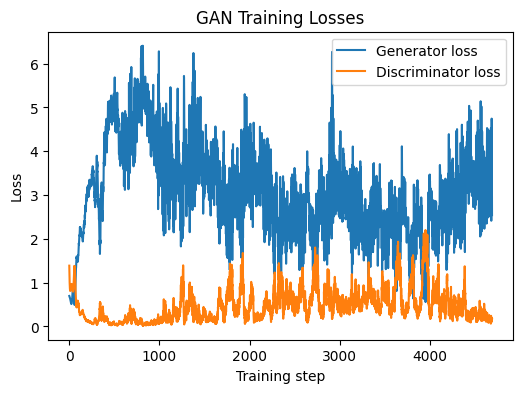

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(G_losses, label="Generator loss")
plt.plot(D_losses, label="Discriminator loss")
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("GAN Training Losses")
plt.legend()
plt.show()


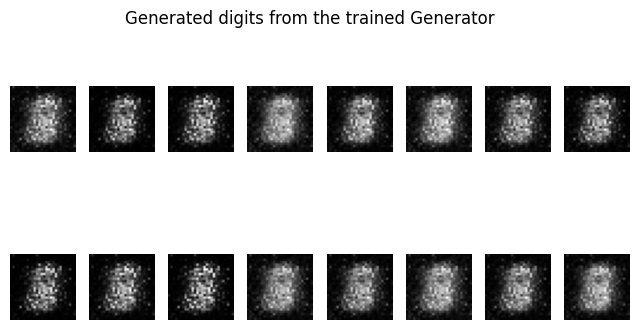

Generator(
  (model): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [14]:
# Use the fixed noise we saved earlier so we can see consistent outputs
generator.eval()
with torch.no_grad():
    fake_samples = generator(fixed_noise).cpu()

# Plot the fake images
plt.figure(figsize=(8, 4))
for i in range(16):
    plt.subplot(2, 8, i + 1)
    img = fake_samples[i].squeeze().numpy()
    # Convert from [-1,1] back to [0,1] for display
    img = (img + 1) / 2
    plt.imshow(img, cmap="gray")
    plt.axis("off")
plt.suptitle("Generated digits from the trained Generator")
plt.show()

generator.train()


## Summary

In this notebook, we:

- Loaded the **MNIST** dataset of handwritten digits (28×28 grayscale images).
- Defined a simple **Generator** network that maps random noise to fake images.
- Defined a simple **Discriminator** network that scores images as real or fake.
- Trained the two networks together in an **adversarial game**:
  - The discriminator learned to distinguish real vs. fake images.
  - The generator learned to produce images that fool the discriminator.
- Visualized the final generated digits.

Even though this GAN is very small and simple, it is already able to generate digit-like images.
More advanced GANs use deeper networks and more complex tricks to generate high-resolution,
realistic images of faces, objects, and scenes.

This notebook is intended as an introductory example for students seeing GANs for the first time.
